# Hydraulijärjestelmän mallin visualisointi

Tässä notebookissa visualisoidaan hydraulijärjestelmän tilan luokitteluun käytetyn mallin tuloksia. Notebook sisältää visualisointiosion testHydraulicDataAccuracy.py-tiedostosta.

## Kirjastojen lataus

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Määritä tiedostojen nimet
MODEL_FILENAME = "SVM.pkl"
SCALER_FILENAME = "hydraulicScaler.joblib"

## Datan ja mallin lataus

Ladataan hydrauliikkadata, malli ja skaaleri visualisointia varten.

In [2]:
def loadHydraulicData():
    """
    Lataa hydraulicData.csv-tiedosto
    """
    try:
        # Määritä tiedostojen polut
        currentDir = os.path.dirname(os.path.abspath("__file__"))
        dataDir = os.path.join(os.path.dirname(currentDir), 'Data')
        
        # Lataa hydraulicData.csv
        hydraulicDataPath = os.path.join(dataDir, 'hydraulicData.csv')
        
        if not os.path.exists(hydraulicDataPath):
            print(f"Virhe: Tiedostoa {hydraulicDataPath} ei löydy")
            sys.exit(1)
        
        hydraulicData = pd.read_csv(hydraulicDataPath)
        
        print(f"Ladattu hydraulicData: {hydraulicDataPath}")
        
        # Erota syöte- ja kohdemuuttujat
        xHydraulic = hydraulicData[['pumpControl', 'pressure']]
        yHydraulic = hydraulicData['state']
        
        # Muunna luokkamuuttujat numeerisiksi
        labelEncoder = LabelEncoder()
        yHydraulicEncoded = labelEncoder.fit_transform(yHydraulic)
        
        # Tallenna luokkien nimet
        classNames = labelEncoder.classes_
        
        return xHydraulic, yHydraulicEncoded, classNames
    except Exception as e:
        print(f"Virhe hydraulicDatan lataamisessa: {e}")
        sys.exit(1)

def loadModelAndScaler():
    """
    Lataa malli ja skaaleri
    """
    try:
        # Määritä tiedostojen polut
        currentDir = os.path.dirname(os.path.abspath("__file__"))
        modelDir = os.path.join(os.path.dirname(currentDir), 'Models')
        
        # Lataa malli ja skaaleri
        modelPath = os.path.join(modelDir, MODEL_FILENAME)
        scalerPath = os.path.join(modelDir, SCALER_FILENAME)
        
        if not os.path.exists(modelPath) or not os.path.exists(scalerPath):
            print(f"Virhe: Tiedostoja {modelPath} tai {scalerPath} ei löydy")
            sys.exit(1)
        
        # Lataa malli ja skaaleri
        import pickle
        import joblib
        
        with open(modelPath, 'rb') as f:
            model = pickle.load(f)
        
        scaler = joblib.load(scalerPath)
        
        return model, scaler
    except Exception as e:
        print(f"Virhe mallin ja skaalerin lataamisessa: {e}")
        sys.exit(1)

# Ladataan data, malli ja skaaleri
xHydraulic, yHydraulic, classNames = loadHydraulicData()
model, scaler = loadModelAndScaler()

print(f"Käytössä malli: {MODEL_FILENAME}")
print(f"Käytössä skaaleri: {SCALER_FILENAME}")

Ladattu hydraulicData: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Data\hydraulicData.csv
Käytössä malli: SVM.pkl
Käytössä skaaleri: hydraulicScaler.joblib


## Datan valmistelu visualisointia varten

Skaalataan data ja tehdään ennusteet visualisointia varten.

In [3]:
# Skaalaa arvot manuaalisesti välille [0, 1]
print("\nSkaalataan arvot...")

# Määritä skaalauksen rajat
pumpControlMin = 18
pumpControlMax = 101
pressureMin = 1
pressureMax = 432

# Skaalaa arvot
xHydraulicScaled = xHydraulic.copy()
xHydraulicScaled['pumpControl'] = xHydraulic['pumpControl'].apply(
    lambda x: max(0, min(1, (x - pumpControlMin) / (pumpControlMax - pumpControlMin)))
)
xHydraulicScaled['pressure'] = xHydraulic['pressure'].apply(
    lambda x: max(0, min(1, (x - pressureMin) / (pressureMax - pressureMin)))
)

# Tee ennusteet
predictions = model.predict(xHydraulicScaled)

# Laske tarkkuus
accuracy = accuracy_score(yHydraulic, predictions)
print(f"\nMallin tarkkuus: {accuracy:.4f} ({accuracy*100:.2f}%)")

# Laske sekaannusmatriisi
allLabels = np.arange(len(classNames))
cm = confusion_matrix(yHydraulic, predictions, labels=allLabels)

# Valmistele data visualisointia varten
hydraulicDataWithPredictions = pd.DataFrame({
    'pumpControl': xHydraulic['pumpControl'],
    'pumpControlScaled': xHydraulicScaled['pumpControl'],
    'pressure': xHydraulic['pressure'],
    'pressureScaled': xHydraulicScaled['pressure'],
    'actual': [classNames[i] for i in yHydraulic],
    'predicted': [classNames[i] for i in predictions]
})

# Tunnista virheelliset luokittelut
errors = hydraulicDataWithPredictions[hydraulicDataWithPredictions['actual'] != hydraulicDataWithPredictions['predicted']]
print(f"Virheellisiä luokitteluja: {len(errors)} / {len(hydraulicDataWithPredictions)} ({len(errors)/len(hydraulicDataWithPredictions)*100:.2f}%)")

# Käytä olemassa olevaa visualisointikansiota
def getVisualizationDirectory():
    """
    Palauttaa olemassa olevan Visualization-kansion polun
    """
    currentDir = os.path.dirname(os.path.abspath("__file__"))
    projectRoot = os.path.dirname(currentDir)
    visualizationDir = os.path.join(projectRoot, 'Visualization')
    
    if not os.path.exists(visualizationDir):
        os.makedirs(visualizationDir)
        print(f"Luotu Visualization-kansio: {visualizationDir}")
    
    return visualizationDir

# Käytä olemassa olevaa visualisointikansiota
visualizationDir = getVisualizationDirectory()
print(f"Käytetään visualisointikansiota: {visualizationDir}")


Skaalataan arvot...

Mallin tarkkuus: 0.9902 (99.02%)
Virheellisiä luokitteluja: 98 / 10000 (0.98%)
Käytetään visualisointikansiota: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization


## Sekaannusmatriisin visualisointi

Visualisoidaan sekaannusmatriisi lämpökarttana.

Sekaannusmatriisi tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\confusion_matrix.png


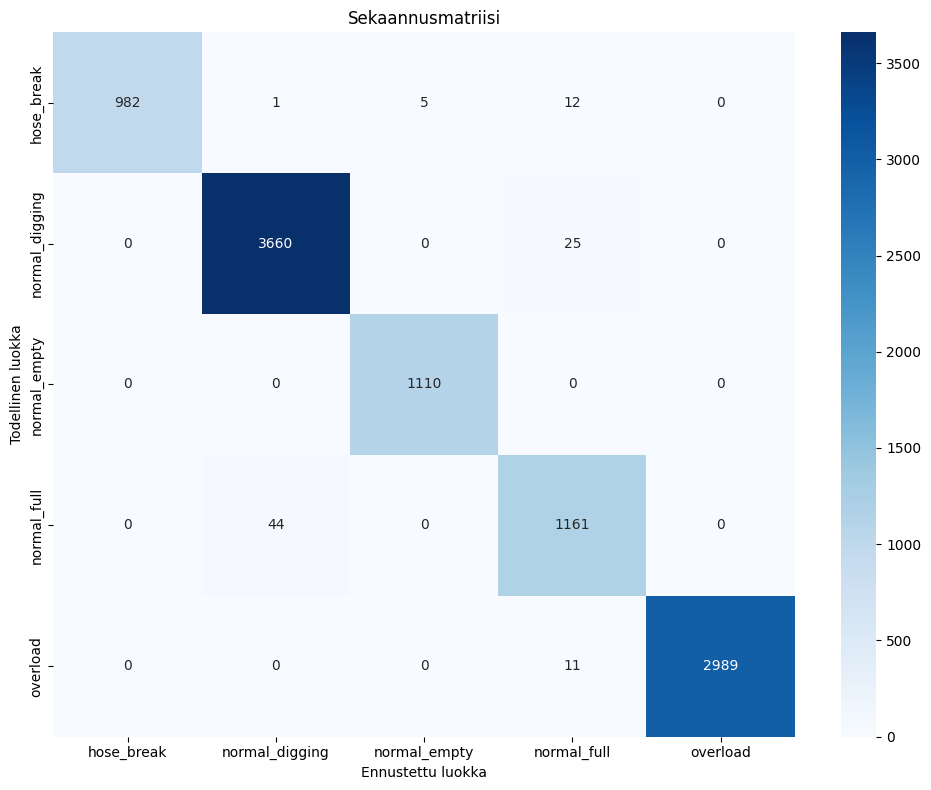

In [4]:
def plotConfusionMatrix(cm, classNames, visualizationDir):
    """
    Visualisoi sekaannusmatriisi
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classNames, yticklabels=classNames)
    plt.xlabel('Ennustettu luokka')
    plt.ylabel('Todellinen luokka')
    plt.title('Sekaannusmatriisi')
    plt.tight_layout()
    
    # Tallenna kuva
    confusionMatrixPath = os.path.join(visualizationDir, 'confusion_matrix.png')
    plt.savefig(confusionMatrixPath)
    print(f"Sekaannusmatriisi tallennettu: {confusionMatrixPath}")
    
    return plt

# Visualisoidaan sekaannusmatriisi
plt_cm = plotConfusionMatrix(cm, classNames, visualizationDir)
plt_cm.show()

## Luokkien jakaumien visualisointi

Visualisoidaan todellisten ja ennustettujen luokkien jakaumat.

Luokkien jakauma tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\class_distribution.png


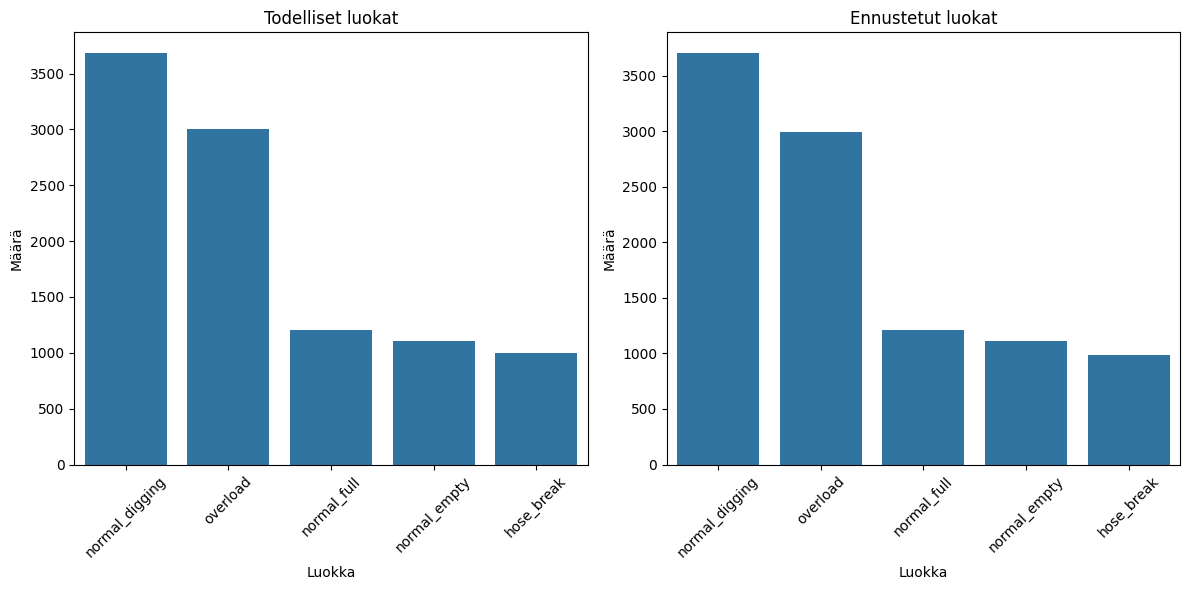

In [5]:
def plotClassDistribution(hydraulicData, visualizationDir):
    """
    Visualisoi luokkien jakaumat
    """
    plt.figure(figsize=(12, 6))
    
    # Todellisten luokkien jakauma
    plt.subplot(1, 2, 1)
    actualCounts = hydraulicData['actual'].value_counts()
    sns.barplot(x=actualCounts.index, y=actualCounts.values)
    plt.title('Todelliset luokat')
    plt.xlabel('Luokka')
    plt.ylabel('Määrä')
    plt.xticks(rotation=45)
    
    # Ennustettujen luokkien jakauma
    plt.subplot(1, 2, 2)
    predictedCounts = hydraulicData['predicted'].value_counts()
    sns.barplot(x=predictedCounts.index, y=predictedCounts.values)
    plt.title('Ennustetut luokat')
    plt.xlabel('Luokka')
    plt.ylabel('Määrä')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    
    # Tallenna kuva
    distributionPath = os.path.join(visualizationDir, 'class_distribution.png')
    plt.savefig(distributionPath)
    print(f"Luokkien jakauma tallennettu: {distributionPath}")
    
    return plt

# Visualisoidaan luokkien jakaumat
plt_dist = plotClassDistribution(hydraulicDataWithPredictions, visualizationDir)
plt_dist.show()

## Ominaisuuksien jakaumien ja virheellisten luokittelujen visualisointi

Visualisoidaan ominaisuuksien jakaumat luokittain ja virheelliset luokittelut.

Ominaisuuksien jakaumat tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\feature_scatterplot.png


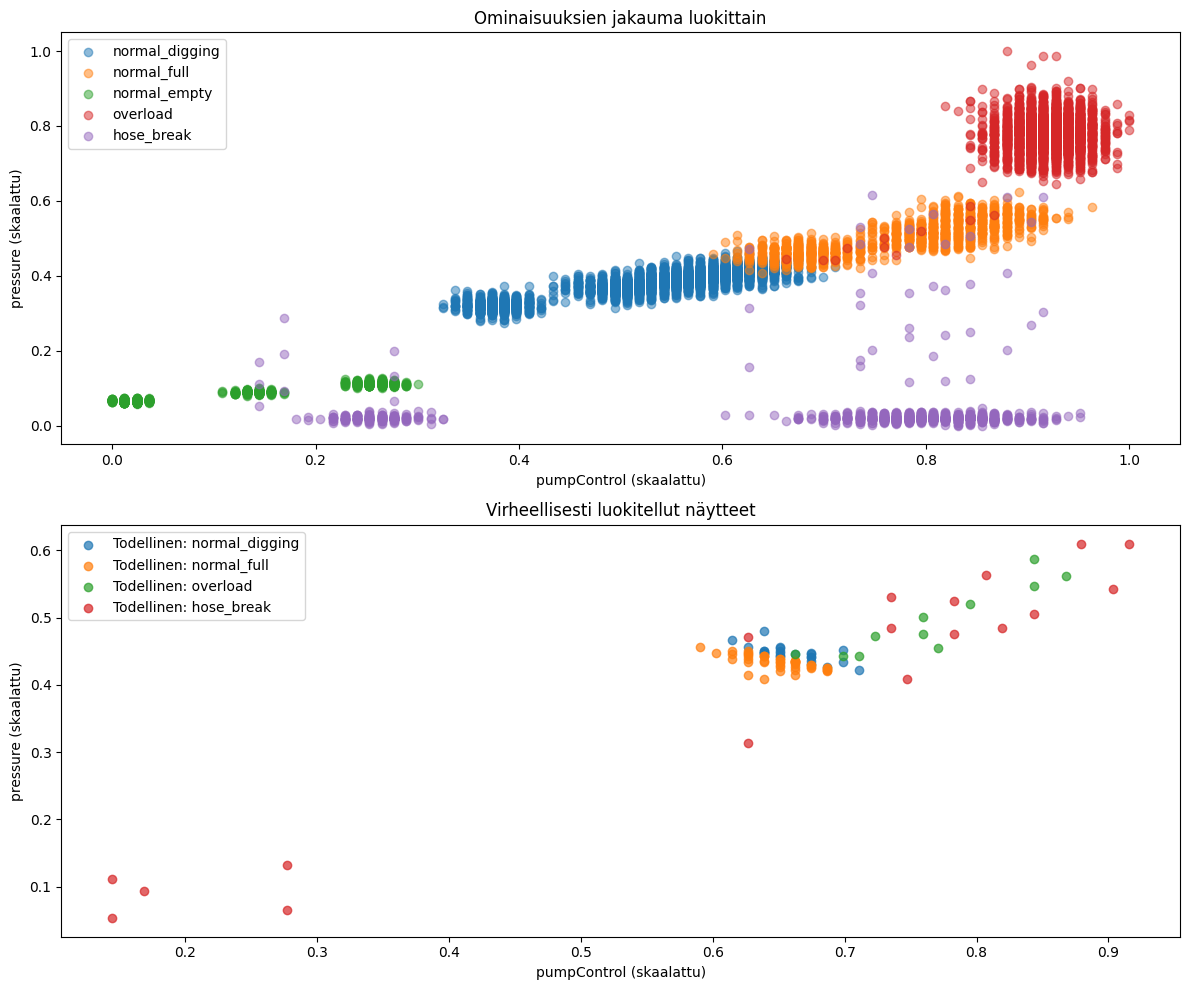

In [6]:
def plotFeatureScatterplot(hydraulicData, visualizationDir):
    """
    Visualisoi ominaisuuksien jakaumat ja virheelliset luokittelut
    """
    plt.figure(figsize=(12, 10))
    
    # Kaikki näytteet
    plt.subplot(2, 1, 1)
    for className in hydraulicData['actual'].unique():
        mask = hydraulicData['actual'] == className
        plt.scatter(
            hydraulicData.loc[mask, 'pumpControlScaled'], 
            hydraulicData.loc[mask, 'pressureScaled'],
            label=className, alpha=0.5
        )
    plt.title('Ominaisuuksien jakauma luokittain')
    plt.xlabel('pumpControl (skaalattu)')
    plt.ylabel('pressure (skaalattu)')
    plt.legend()
    
    # Virheelliset luokittelut
    plt.subplot(2, 1, 2)
    errors = hydraulicData[hydraulicData['actual'] != hydraulicData['predicted']]
    if len(errors) > 0:
        for className in errors['actual'].unique():
            mask = errors['actual'] == className
            plt.scatter(
                errors.loc[mask, 'pumpControlScaled'], 
                errors.loc[mask, 'pressureScaled'],
                label=f"Todellinen: {className}", alpha=0.7
            )
        plt.title('Virheellisesti luokitellut näytteet')
        plt.xlabel('pumpControl (skaalattu)')
        plt.ylabel('pressure (skaalattu)')
        plt.legend()
    else:
        plt.text(0.5, 0.5, "Ei virheellisiä luokitteluja!", 
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
        plt.title('Virheellisesti luokitellut näytteet')
    
    plt.tight_layout()
    
    # Tallenna kuva
    scatterplotPath = os.path.join(visualizationDir, 'feature_scatterplot.png')
    plt.savefig(scatterplotPath)
    print(f"Ominaisuuksien jakaumat tallennettu: {scatterplotPath}")
    
    return plt

# Visualisoidaan ominaisuuksien jakaumat ja virheelliset luokittelut
plt_scatter = plotFeatureScatterplot(hydraulicDataWithPredictions, visualizationDir)
plt_scatter.show()

## Päätösrajapintojen visualisointi

Visualisoidaan mallin päätösrajapinnat.

c:\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Päätösrajapinnat tallennettu: d:\Rakentelu\Projektit\10_LED_ohjain_2313_baremetal_ML\HydraulicControlML\Visualization\decision_boundaries.png


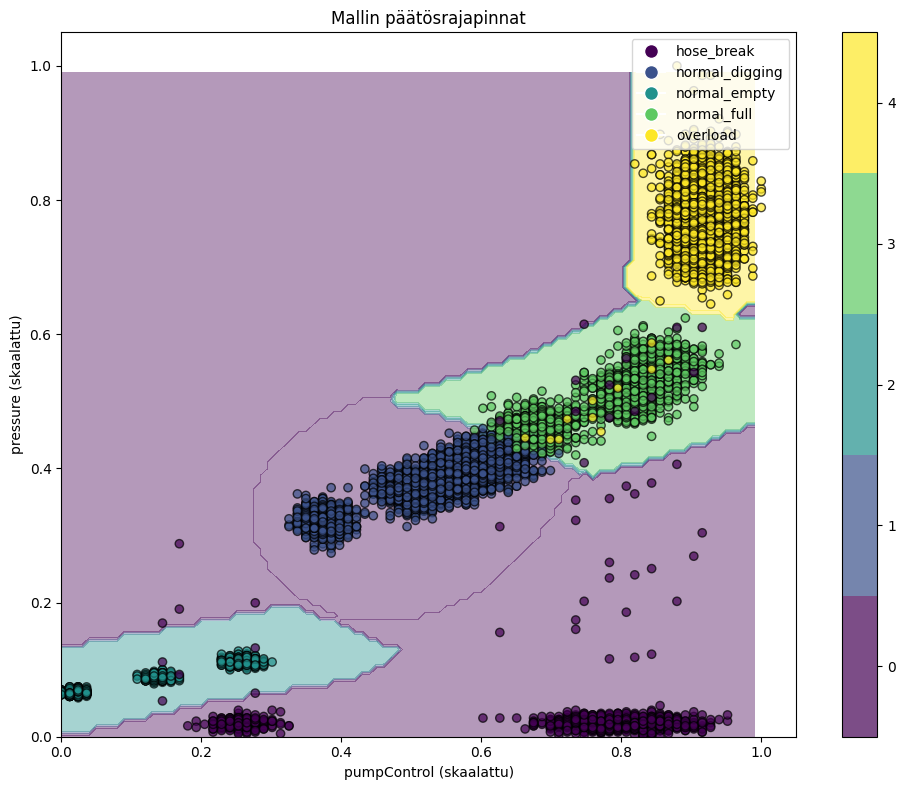

In [10]:
def plotDecisionBoundaries(model, hydraulicData, classNames, visualizationDir):
    """
    Visualisoi mallin päätösrajapinnat
    """
    # Luo ruudukko ennustetta varten
    h = 0.01  # ruudukon tiheys
    x_min, x_max = 0, 1
    y_min, y_max = 0, 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Tee ennusteet ruudukolle
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Visualisoi päätösrajapinnat
    plt.figure(figsize=(10, 8))
    
    # Luo värikartta luokille - korjattu syntaksi
    import matplotlib as mpl
    cmap = mpl.colormaps['viridis'].resampled(len(classNames))
    
    # Piirrä päätösrajapinnat
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap)
    
    # Piirrä todelliset näytteet
    scatter = plt.scatter(
        hydraulicData['pumpControlScaled'], 
        hydraulicData['pressureScaled'],
        c=np.array([list(classNames).index(c) for c in hydraulicData['actual']]), 
        cmap=cmap,
        edgecolor='k', alpha=0.7
    )
    
    # Lisää selite
    plt.colorbar(scatter, ticks=range(len(classNames)))
    plt.clim(-0.5, len(classNames)-0.5)
    
    # Lisää otsikot
    plt.title('Mallin päätösrajapinnat')
    plt.xlabel('pumpControl (skaalattu)')
    plt.ylabel('pressure (skaalattu)')
    
    # Lisää selite luokille
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) 
              for i in range(len(classNames))]
    plt.legend(handles, classNames, loc='upper right')
    
    plt.tight_layout()
    
    # Tallenna kuva
    boundaryPath = os.path.join(visualizationDir, 'decision_boundaries.png')
    plt.savefig(boundaryPath)
    print(f"Päätösrajapinnat tallennettu: {boundaryPath}")
    
    return plt

# Visualisoidaan päätösrajapinnat
plt_boundaries = plotDecisionBoundaries(model, hydraulicDataWithPredictions, classNames, visualizationDir)
plt_boundaries.show()

## Visualisointien yhteenveto

Tässä notebookissa olemme visualisoineet hydrauliikkajärjestelmän tilan luokittelumallin tuloksia useilla eri tavoilla:

1. **Sekaannusmatriisi**: Näyttää, kuinka hyvin malli luokittelee eri tilat ja missä virheet tapahtuvat.

2. **Luokkien jakaumat**: Vertailee todellisten ja ennustettujen luokkien jakaumia.

3. **Ominaisuuksien jakaumat**: Näyttää, miten eri luokat jakautuvat ominaisuusavaruudessa ja missä virheelliset luokittelut tapahtuvat.

4. **Päätösrajapinnat**: Visualisoi mallin tekemät päätökset koko ominaisuusavaruudessa.

Visualisoinnit osoittavat, että SVM-malli pystyy erottamaan hydrauliikkajärjestelmän eri tilat erittäin hyvin. Virheelliset luokittelut ovat harvinaisia ja keskittyvät pääasiassa luokkien rajapinnoille.

Päätösrajapintojen visualisointi on erityisen hyödyllinen, sillä se näyttää selkeästi, miten malli jakaa ominaisuusavaruuden eri luokkiin. Tämä auttaa ymmärtämään mallin toimintaa ja mahdollisia virhelähteitä.